In [15]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import (
    draw_temporal,
    draw_cumulative,
    draw_cumulative_final,
)

In [16]:
metaserieses = [18, 18, 18, 18]
serieses = [60, 62, 61, 64]

series_names = None
# series_names = {
#     # 1: "IPA-accuracy",
#     2: "IPA",
#     # 3: "IPA-cost",
#     4: "FA2-high",
#     # 5: "FA2-high",
#     # 6: "RIM-low",
#     7: "RIM-high",
# }


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"

metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Normalized Accuracy",
        "ylabel": "Normalized Accuracy",
    },
    # METRIC_MEASURED_LATENCY: {
    #     "title": "Latency",
    #     "ylabel": "Latency (s)",
    # },
    # METRIC_TIMEOUT_DICS: {
    #     "title": "SLA Violations",
    #     "ylabel": "SLA Violations (%)",
    # },
}

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [17]:
accuracy_methods = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': 'scale',
    'batching_cap': 1,
    'benchmark_duration': 1,
    'beta': 0.125,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 5,
    'gamma': 1e-06,
    'initial_active_model': [   'sshleifer-distilbart-xsum-1-1',
                                'deepset-xlm-roberta-base-squad2'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'metadata': 'bursty - fa2-low - cpu type: compute_cascadelake_r_ib',
    'metaseries': 18,
    'mode': 'exponential',
    'model_name': ['nlp-sum', 'nlp-qa'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'text',
                     'max_batch_size':

In [18]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [19]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

## Replica Changes
1. Total
2. Per node

In [20]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [21]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

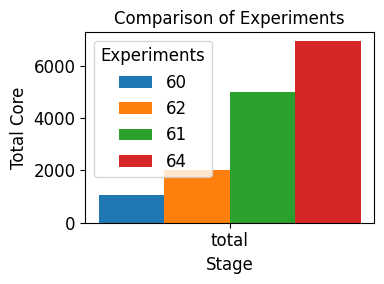

In [22]:
total_core_changes = {}
only_total = {}
for_final_cost = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    only_total[series] = {}
    only_total[series]["total"] = total_core_changes[series]["total"]
    for_final_cost[series] = sum(only_total[series]["total"]) / len(
        only_total[series]["total"]
    )

ylabel = "Total Core"
draw_cumulative(
    only_total,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

## Accuracy Changes

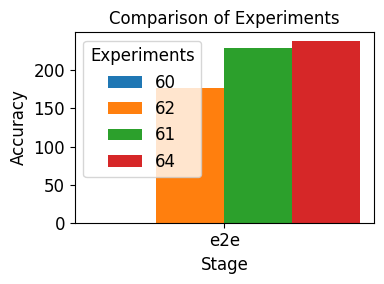

In [23]:
accuracy_changes = {}
only_e2e = {}
for_final_accuracy = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    only_e2e[series] = {}
    only_e2e[series]["e2e"] = accuracy_changes[series]["e2e"]
    for_final_accuracy[series] = sum(only_e2e[series]["e2e"]) / len(
        only_e2e[series]["e2e"]
    )

ylabel = "Accuracy"

draw_cumulative(
    only_e2e,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

In [24]:
results = {"cost": for_final_cost, "accuracy": for_final_accuracy}

In [25]:
metrics_metadata

{'cost': {'title': 'Cost', 'ylabel': 'Cost (cores)'},
 'accuracy': {'title': 'Normalized Accuracy', 'ylabel': 'Normalized Accuracy'}}

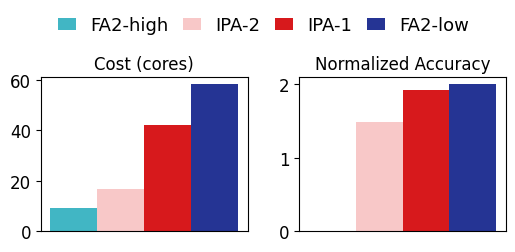

In [26]:
series_metadata = {
    60: {"label": "FA2-high", "color": "#41b6c4"},
    61: {"label": "IPA-1", "color": "#d7191c"},
    62: {"label": "IPA-2", "color": "#f8c8c8"},
    # 63: {"label": "RIM-low", "color": ""},
    64: {"label": "FA2-low", "color": "#253494"},
}

draw_cumulative_final(
    results,
    series_metadata,
    metrics_metadata,
    filename=f"{FIGURES_PATH}/early-comparison",
    bbox_to_anchor=(0.9, 1.5),
    figsize=(6, 2)
    
)